In [1]:
import numpy as np
import pandas as pd
import scipy.special
import scipy.stats as st

import pystan

import bebi103

import altair as alt
import altair_catplot as altcat

import bokeh.io
import bokeh.plotting
bokeh.io.output_notebook()

import numba

Loading BokehJS ...

In [2]:
cd ~/git/BE-Bi-103/Codes

/Users/Sanyo 1/git/BE-Bi-103/Codes


In [3]:
df = pd.read_csv('../data/finch_beaks.csv', comment='#')
df.head()

,band,species,beak length (mm),beak depth (mm),year
0,20123,fortis,9.25,8.05,1973
1,20126,fortis,11.35,10.45,1973
2,20128,fortis,10.15,9.55,1973
3,20129,fortis,9.95,8.75,1973
4,20133,fortis,11.55,10.15,1973


In [4]:
df.shape

(2304, 5)

In [5]:
pd.concat(g for _,g in df.groupby(['band','year']) if len(g) > 1)

,band,species,beak length (mm),beak depth (mm),year
102,316,fortis,10.9,9.70,1975
103,316,fortis,10.9,9.85,1975
304,818,fortis,10.2,9.00,1975
305,818,fortis,10.2,9.00,1975
363,944,fortis,10.3,8.30,1975
364,944,fortis,10.3,8.30,1975
365,945,fortis,11.6,10.80,1975
366,945,fortis,11.6,10.80,1975
2057,19028,fortis,12.5,8.90,2012
2178,19028,scandens,12.5,8.90,2012


In [6]:
df_deduped = df.drop_duplicates()
df_deduped = df_deduped.drop([2057,2178,102,103])

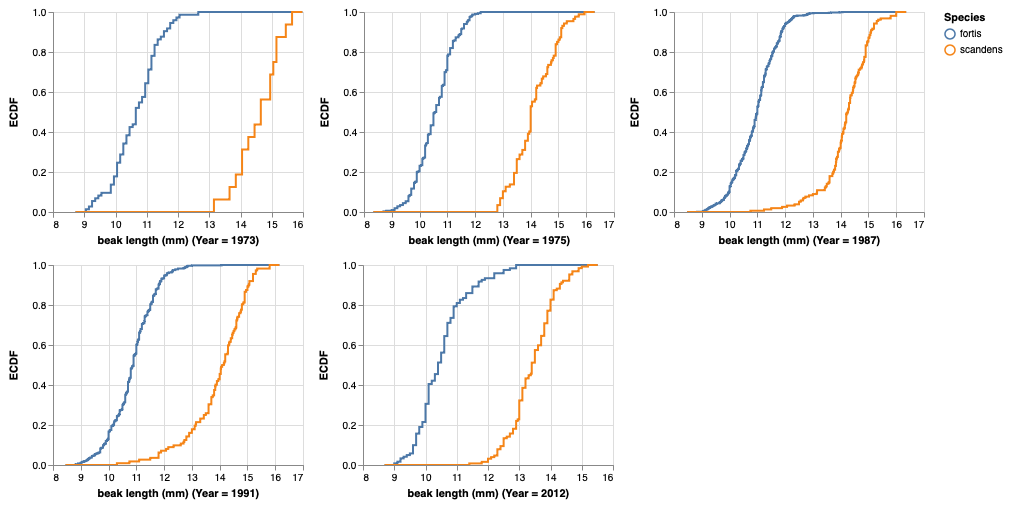

In [7]:
p = []
for t in df['year'].unique().astype('int'):
    p_temp = altcat.catplot(data=df.loc[df['year'] == t,:],
                        height=200,
                        width=250,
                        mark='line',
                        encoding=dict(x=alt.X('beak length (mm):Q',title='beak length (mm) (Year = ' + str(t) + ')'),
                                     color=alt.Color('species:N', title='Species')),
                        transform='ecdf')
    p.append(p_temp)


(p[-5] | p[-4] | p[-3]) & (p[-2] | p[-1])

In [40]:
@numba.jit(nopython=True)
def draw_bs_sample(data):
    """
    Draw a bootstrap sample from a 1D data set.
    """
    return np.random.choice(data, size=len(data))

@numba.jit(nopython=True)
def draw_bs_reps_mean(data, size=1):
    """
    Draw boostrap replicates of the mean from 1D data set.
    """
    out = np.empty(size)
    for i in range(size):
        out[i] = np.mean(draw_bs_sample(data))
    return out

@numba.jit(nopython=True)
def mean_conf_int(data, size=1, alpha=5):
    out = np.empty(size)
    for i in range(size):
        out[i] = np.mean(draw_bs_sample(data))
    return np.percentile(out, [alpha/2, 100-alpha/2])

In [35]:
depth_s_1975 = df_deduped.loc[((df_deduped['species'] == 'scandens') &
        (df_deduped['year'] == 1975)),'beak depth (mm)'].values
    
depth_s_2012 = df_deduped.loc[((df_deduped['species'] == 'scandens') &
        (df_deduped['year'] == 2012)),'beak depth (mm)'].values

print("""
G. scandens mean beak depths 95% conf int 1975 (mm):   [{0:.2f}, {1:.2f}]
G. scandens mean beak depths 95% conf int 2012 (mm): [{2:.2f}, {3:.2f}]
""".format(*(tuple(mean_conf_int(depth_s_1975, size=10000)) + tuple(mean_conf_int(depth_s_2012, size=10000)))))


G. scandens mean beak depths 95% conf int 1975 (mm):   [8.85, 9.08]
G. scandens mean beak depths 95% conf int 2012 (mm): [9.07, 9.30]



In [10]:
@numba.jit(nopython=True)
def draw_perm_sample(x, y):
    """Generate a permutation sample."""
    concat_data = np.concatenate((x, y))
    np.random.shuffle(concat_data)
    return concat_data[:len(x)], concat_data[len(x):]

@numba.jit(nopython=True)
def draw_perm_reps_diff_mean(x, y, size=1):
    """
    Generate array of permuation replicates.
    """
    out = np.empty(size)
    for i in range(size):
        x_perm, y_perm = draw_perm_sample(x, y)
        out[i] = np.mean(x_perm) - np.mean(y_perm)
    return out

In [11]:
# Compute test statistic for original data set
diff_mean = np.mean(depth_s_2012) - np.mean(depth_s_1975)

# Draw replicates
perm_reps = abs(draw_perm_reps_diff_mean(depth_s_1975, depth_s_2012, size=100000))

# Compute p-value
p_val = np.sum(perm_reps >= diff_mean) / len(perm_reps)

print('p-value =', p_val)

p-value = 0.0099


In [12]:
diff_mean

0.2284920634920642

In [13]:
df_hf = pd.read_csv('../data/fortis_beak_depth_heredity.csv', comment='#')
df_hf['mid_parent'] = (df_hf['Male BD'] + df_hf['Female BD']) / 2
df_hf['mid_offspring'] = df_hf['Mid-offspr']
df_hf = df_hf.drop(columns=['Male BD', 'Female BD', 'Mid-offspr'])
df_hf.shape

(413, 2)

In [14]:
hf_par = df_hf['mid_parent'].values
hf_offsp = df_hf['mid_offspring'].values

In [15]:
df_hs = pd.read_csv('../data/scandens_beak_depth_heredity.csv', comment='#')

In [16]:
hs_par = df_hs['mid_parent'].values
hs_offsp = df_hs['mid_offspring'].values

In [17]:
@numba.jit(nopython=True)
def draw_bs_pairs(x, y):
    """
    Draw a pairs bootstrap sample.
    """
    inds = np.arange(len(x))
    bs_inds = draw_bs_sample(inds)
    return x[bs_inds], y[bs_inds]

@numba.jit(nopython=True)
def heritability(par, offsp):
    
    assert len(par) == len(offsp), 'Length of the arrays must be the same.'

    return np.sum((par - np.mean(par)) * (offsp - np.mean(offsp))) \
            / np.sum((par - np.mean(par)) * (par - np.mean(par)))

In [18]:
@numba.jit(nopython=True)
def draw_bs_pairs_reps_heritability(x, y, size=1):
    """
    Draw bootstrap pairs replicates.
    """
    out = np.empty(size)
    for i in range(size):
        out[i] = heritability(*draw_bs_pairs(x, y))
    return out

In [19]:
hf_reps = draw_bs_pairs_reps_heritability(hf_par, hf_offsp, size=10000)
hs_reps = draw_bs_pairs_reps_heritability(hs_par, hs_offsp, size=10000)

conf_int_hf = np.percentile(hf_reps, [2.5, 97.5])
conf_int_hs = np.percentile(hs_reps, [2.5, 97.5])

print("""
G. f heritability 95% conf int (mm):   [{0:.2f}, {1:.2f}]
G. scandens heritability 95% conf int (mm): [{2:.2f}, {3:.2f}]
""".format(*(tuple(conf_int_hf) + tuple(conf_int_hs))))


G. f heritability 95% conf int (mm):   [0.65, 0.80]
G. scandens heritability 95% conf int (mm): [0.35, 0.75]



In [20]:
p = bebi103.viz.ecdf(hs_reps, formal=True, line_width=2, color='#4e79a7')
p = bebi103.viz.ecdf(hf_reps, p=p, formal=True, line_width=2, color='#f28e2b')

bokeh.io.show(p)

In [21]:
df_deduped.head()

,band,species,beak length (mm),beak depth (mm),year
0,20123,fortis,9.25,8.05,1973
1,20126,fortis,11.35,10.45,1973
2,20128,fortis,10.15,9.55,1973
3,20129,fortis,9.95,8.75,1973
4,20133,fortis,11.55,10.15,1973


In [22]:
df_deduped['beak length to depth ratio'] = df_deduped['beak length (mm)'] / df_deduped['beak depth (mm)']
df_deduped.head()

,band,species,beak length (mm),beak depth (mm),year,beak length to depth ratio
0,20123,fortis,9.25,8.05,1973,1.149068
1,20126,fortis,11.35,10.45,1973,1.086124
2,20128,fortis,10.15,9.55,1973,1.062827
3,20129,fortis,9.95,8.75,1973,1.137143
4,20133,fortis,11.55,10.15,1973,1.137931


In [24]:
p = bebi103.viz.ecdf(alpha_s['beak length to depth ratio'], formal=False, size=4, fill_alpha=0, color='#4e79a7')
p = bebi103.viz.ecdf(alpha_f['beak length to depth ratio'], p=p, formal=False, size=4, fill_alpha=0, color='#f28e2b')

years = df_deduped['year'].unique()
marker_year = np.linspace(0.2, 0.6, len(years))

for i, year in enumerate(df_deduped['year'].unique()):
    p = bebi103.viz.ecdf(alpha_f.loc[alpha_f['year'] == year, 'beak length to depth ratio'], p=p, formal=True, line_width=2, color='#f28e2b', alpha = marker_year[i])
    p = bebi103.viz.ecdf(alpha_s.loc[alpha_s['year'] == year, 'beak length to depth ratio'], p=p, formal=True, line_width=2, color='#4e79a7', alpha = marker_year[i])
    
bokeh.io.show(p)

In [39]:
print("""
G. f mean beak ratio 95% conf int 1975 (mm):   [{0:.2f}, {1:.2f}]
G. f mean beak ratio 95% conf int 2012 (mm): [{2:.2f}, {3:.2f}]
""".format(*(tuple(mean_conf_int(alpha_f.loc[alpha_f['year'] == 1975, 'beak length to depth ratio'].values, size=10000)) + 
             tuple(mean_conf_int(alpha_f.loc[alpha_f['year'] == 2012, 'beak length to depth ratio'].values, size=10000)))))


G. scandens mean beak depths 95% conf int 1975 (mm):   [1.15, 1.16]
G. scandens mean beak depths 95% conf int 2012 (mm): [1.21, 1.24]



In [41]:
print("""
G. scandens mean beak ratio 95% conf int 1975 (mm):   [{0:.2f}, {1:.2f}]
G. scandens mean beak ratio 95% conf int 2012 (mm): [{2:.2f}, {3:.2f}]
""".format(*(tuple(mean_conf_int(alpha_s.loc[alpha_s['year'] == 1975, 'beak length to depth ratio'].values, size=10000)) + 
             tuple(mean_conf_int(alpha_s.loc[alpha_s['year'] == 2012, 'beak length to depth ratio'].values, size=10000)))))


G. scandens mean beak ratio 95% conf int 1975 (mm):   [1.56, 1.60]
G. scandens mean beak ratio 95% conf int 2012 (mm): [1.45, 1.48]

